# Selections of random dates

## Modules and functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [1]:
import bottleneck as bn
import pandas as pd
import numpy as np
import ordpy
import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
import os 
from SWx_modules.visualising.description import describe_dataframe
from SWx_modules.file_management.savloading import load_folder, save, load
from SWx_modules.file_management.wind3sfromcdas import Wind3sFromCdas
from SWx_modules.preprocessing.nan_interp import nan_helper

In [3]:
# Matplotlib config
%matplotlib widget

plt.rcParams['text.usetex'] = True
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('font', size=20)
rc('lines',linewidth=1)
numfig = 0

## Parameters

In [3]:
PL_len = np.geomspace(4,3600,10,dtype=int)
PL_len, PL_len*24, PL_len*24/60, PL_len*24/60/60

(array([   4,    8,   18,   38,   82,  175,  372,  793, 1690, 3600]),
 array([   96,   192,   432,   912,  1968,  4200,  8928, 19032, 40560,
        86400]),
 array([   1.6,    3.2,    7.2,   15.2,   32.8,   70. ,  148.8,  317.2,
         676. , 1440. ]),
 array([ 0.02666667,  0.05333333,  0.12      ,  0.25333333,  0.54666667,
         1.16666667,  2.48      ,  5.28666667, 11.26666667, 24.        ]))

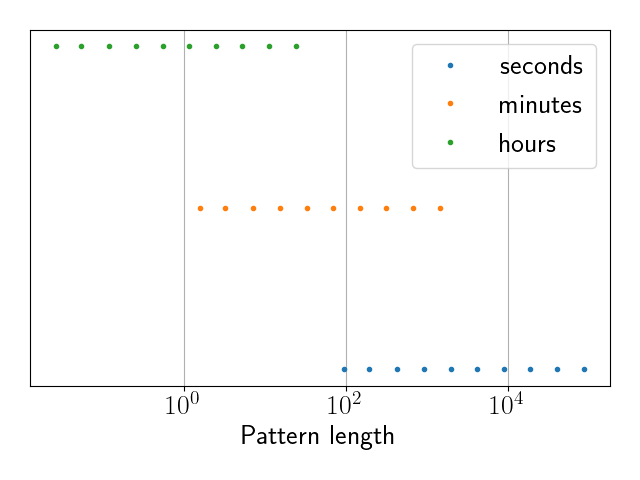

In [ ]:
plt.figure('pattern length',clear=True)
plt.clf()
ax = plt.gca()
ax.plot(PL_len*24,PL_len*0,'.',label='seconds')
ax.plot(PL_len*24/60,PL_len*0+1,'.',label='minutes')
ax.plot(PL_len*24/60/60,PL_len*0+2,'.',label='hours')
ax.set_xscale('log')
ax.get_yaxis().set_visible(False)
ax.legend()
ax.grid()
ax.set_xlabel('Pattern length')
plt.tight_layout()
plt.show()

In [94]:
lengths_to_check_for_nan = PL_len

## Original dataset

In [97]:
path = 'C:/Users/pauline/Documents/DATA/Space_Weather_Project/pattern_recognition_forecast/Article/Datasets/'
for f in os.listdir(path):
    if 'wind_plsp_24s_2004' in f:
        file = f
df_quantity = load(path, file, format_name='pkl')
df_quantity = df_quantity[['NAN','GAP']]
print(describe_dataframe(df_quantity))
print(df_quantity.index[0], df_quantity.index[-1])

               NAN           GAP
size     3358798.0  3.358798e+06
nans(%)        0.0  0.000000e+00
count          NaN  3.358798e+06
mean           NaN  9.793176e-02
std            NaN  8.478988e+00
min            NaN  0.000000e+00
25%            NaN  0.000000e+00
50%            NaN  0.000000e+00
75%            NaN  0.000000e+00
max            NaN  8.126000e+03
2004-05-03 00:00:24 2006-11-21 23:59:12


## Filter index to keep dates with minimum of gaps/nan as reference

criteria: 
- no more than 5% of nans in the pattern window
- no gaps of more than 4% of the length in the pattern window 
- no gaps larger than 4% of the maximal pattern window in the future
- at least 24h between to dates

In [191]:
PL_len, PL_len*5/100, PL_len*4/100

(array([   4,    8,   18,   38,   82,  175,  372,  793, 1690, 3600]),
 array([  0.2 ,   0.4 ,   0.9 ,   1.9 ,   4.1 ,   8.75,  18.6 ,  39.65,
         84.5 , 180.  ]),
 array([  0.16,   0.32,   0.72,   1.52,   3.28,   7.  ,  14.88,  31.72,
         67.6 , 144.  ]))

In [105]:
# count in windows 
for length in lengths_to_check_for_nan:
    df_quantity['NAN_B'+str(length)] = bn.move_sum(df_quantity['NAN'],length, min_count=length)/length # count number of nans in the past length
    df_quantity['GAP_B'+str(length)] = bn.move_max(df_quantity['GAP'],length, min_count=length)/length # max size of gaps in the past length
    df_quantity.loc[df_quantity['GAP_B'+str(length)]>1,'GAP_B'+str(length)] = 1
df_quantity['GAP_A'+str(lengths_to_check_for_nan[-1])] = df_quantity['GAP_B'+str(lengths_to_check_for_nan[-1])].shift(periods=-lengths_to_check_for_nan[-1])
df_quantity.replace(np.nan,99,inplace=True)
df_quantity

,NAN,GAP,NAN_B4,GAP_B4,NAN_B8,GAP_B8,NAN_B18,GAP_B18,NAN_B38,GAP_B38,...,GAP_B175,NAN_B372,GAP_B372,NAN_B793,GAP_B793,NAN_B1690,GAP_B1690,NAN_B3600,GAP_B3600,GAP_A3600
2004-05-03 00:00:24,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008333
2004-05-03 00:00:48,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008333
2004-05-03 00:01:12,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008333
2004-05-03 00:01:36,False,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008333
2004-05-03 00:02:00,False,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-11-21 23:57:36,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.074286,0.107527,0.034946,0.076923,0.016393,0.089349,0.008284,0.083056,0.003889,NaN
2006-11-21 23:58:00,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.074286,0.107527,0.034946,0.076923,0.016393,0.089349,0.008284,0.083056,0.003889,NaN
2006-11-21 23:58:24,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.074286,0.107527,0.034946,0.076923,0.016393,0.089349,0.008284,0.083056,0.003889,NaN
2006-11-21 23:58:48,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.074286,0.107527,0.034946,0.076923,0.016393,0.089349,0.008284,0.083056,0.003889,NaN


In [195]:
# apply nans and gaps criteria
criteria = df_quantity[['NAN_B4', 'GAP_B4', 'NAN_B8', 'GAP_B8', 'NAN_B18',
       'GAP_B18', 'NAN_B38', 'GAP_B38', 'NAN_B82', 'GAP_B82', 'NAN_B175',
       'GAP_B175', 'NAN_B372', 'GAP_B372', 'NAN_B793', 'GAP_B793', 'NAN_B1690',
       'GAP_B1690', 'NAN_B3600', 'GAP_B3600', 'GAP_A3600']].copy()
for col in criteria.columns:
    if 'NAN_B' in col:
        criteria[col] = criteria[col] < 0.05
    if 'GAP_B' in col:
        criteria[col] = criteria[col] < 0.04
    if 'GAP_A' in col:
        criteria[col] = criteria[col] < 0.04
criteria_total = (criteria.sum(axis=1) == criteria.shape[1])
good_dates = criteria_total[criteria_total].index
len(criteria_total), criteria_total.sum(), max(criteria_total[criteria_total].index), min(criteria_total[criteria_total].index)


(3358798,
 np.int64(157828),
 Timestamp('2005-12-24 18:07:36'),
 Timestamp('2004-05-04 03:26:24'))

In [206]:
# apply distance criteria
dates_to_keep = [good_dates[0],]
for g in good_dates[1:]:
    if g - dates_to_keep[-1] > pd.to_timedelta(12,unit='h'):
        dates_to_keep.append(g)
len(dates_to_keep)


495

## Random draw of 200 dates
(but keep good dates in previous set)

In [207]:
nb_dates = 200
dates_to_save = []
draw = np.random.choice(len(dates_to_keep), size=nb_dates, replace=False)
dates_to_save = [dates_to_keep[d] for d in draw]
len(dates_to_save)

200

In [219]:
dates_to_save.sort()
distance = [(dates_to_save[d+1]-dates_to_save[d])/datetime.timedelta(hours=1) for d in range(len(dates_to_save)-1)]
print(min(distance),max(distance))
print(np.quantile(distance,0.25),np.quantile(distance,0.75))
print(np.mean(distance),np.std(distance))
print(np.median(distance))

12.006666666666666 421.44
17.063333333333333 72.51333333333334
64.53051926298157 71.67486425873929
40.193333333333335


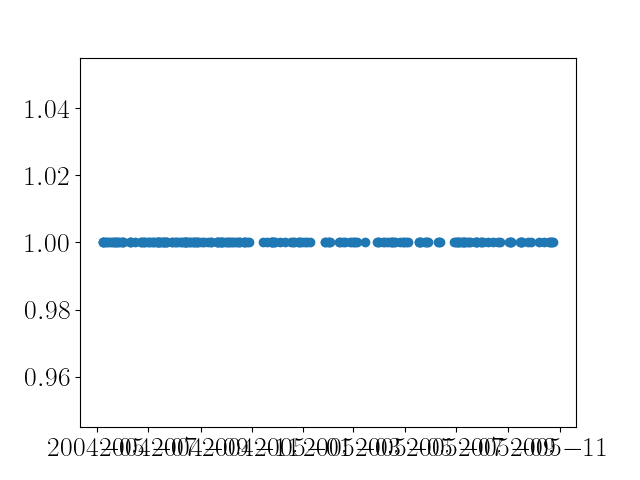

In [223]:
plt.figure('dates')
plt.clf()
plt.scatter(dates_to_save,np.ones(len(dates_to_save)))
plt.show()

In [217]:
save(list(dates_to_save), path, 'dates_5pctnans_4pctgaps_200.json','json')
save({'pattern_size':PL_len,'resolution':'24s'}, path, 'pattern_size_10.json','json')